In [1]:
%load_ext autoreload
%autoreload 2

# Verify conditional circuit generation

We have previously trained a neural network known as a conditional variational autoencoder on genetic circuits. The conditioning variable was made to be one of the characteristics of the genetic circuit's dynamics, for example the sensitivity of the circuit to a signal. While the distributions for each class of conditional variables differ in the AI-generated circuits, the verification of their ground-truth label is still necessary to assess the validity of the conditionality.

## Imports

In [2]:
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.common.setup import prepare_config, expand_config, expand_model_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.misc.numerical import symmetrical_matrix_length
from synbio_morpher.utils.misc.type_handling import flatten_listlike, get_unique
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.solvers import simulate_steady_states

import os
import sys
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import diffrax as dfx

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


np.random.seed(0)
PRNG = jax.random.PRNGKey(0)

jax.devices()

xla_bridge.py:backends():900: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA INFO
xla_bridge.py:backends():900: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory INFO


[cuda(id=0), cuda(id=1)]

In [3]:
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.scripts.verify import verify
from evoscaper.utils.math import arrayise
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.visualise import vis_sampled_histplot


# Use verify function

In [4]:
data_dir = '../data'

hpos_architecture = {
    'seed_arch': 1,
    'hidden_size': 16,
    'enc_ls': 32,
    'dec_ls': 32,
    'num_enc_layers': 2,
    'num_dec_layers': 2,
    'factor_expanding_ls': 1,
    'factor_contracting_ls': 1,
    'model': 'CVAE',
    'use_sigmoid_decoder': False,
    'enc_init': 'HeNormal',
    'dec_init': 'HeNormal',
    'init_model_with_random': True,
    'activation': 'leaky_relu',
}

hpos_training = {
    'seed_train': 1,
    'batch_size': 256,
    'epochs': 3000,
    'patience': 500,
    'learning_rate': 1e-2,
    'loss_func': 'mse',
    'accuracy_func': 'accuracy_regression',
    'use_dropout': False,
    'dropout_rate': 0.1,
    'use_l2_reg': False,
    'l2_reg_alpha': 5e-2,
    'use_kl_div': True,
    # inspired by https://github.com/elttaes/VAE-MNIST-Haiku-Jax/blob/main/cVAE_mnist.ipynb
    'kl_weight': 2.5e-4,
}
hpos_training['print_every'] = hpos_training['epochs'] // 50

hpos_optimization = {
    'seed_opt': 1,
    'opt_method': 'adam',
    'opt_min_lr': 1e-6,
    'opt_min_delta': 1e-4,
    'learning_rate_sched': 'cosine_decay',
    'use_warmup': True,
    'warmup_epochs': 20,
}

hpos_dataset = {
    'seed_dataset': 1,
    'include_diffs': False,
    'objective_col': ('Log sensitivity', 'Log precision'),
    # 'objective_col': 'adaptation',
    # 'objective_col': 'Log sensitivity',
    'output_species': ('RNA_2',),
    'signal_species': ('RNA_0',),
    'filenames_train_config': f'{data_dir}/raw/summarise_simulation/2024_12_05_210221/ensemble_config.json',
    'filenames_train_table': f'{data_dir}/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv',
    'filenames_verify_config': f'{data_dir}/raw/summarise_simulation/2024_11_21_160955/ensemble_config.json',
    'filenames_verify_table': f'{data_dir}/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv',
    'use_test_data': False,
    # 'total_ds': None,   # TO BE RECORDED
    'total_ds_max': 5e6,
    'train_split': 0.8,
    'x_type': 'energies',
    # XY filtering:
    'filt_x_nans': True,
    'filt_y_nans': True,
    'filt_sensitivity_nans': True,
    'filt_precision_nans': True,
    'filt_n_same_x_max': 1,
    'filt_n_same_x_max_bins': 50,
    # XY preprocessing:
    'prep_x_standardise': False,
    'prep_y_standardise': False,
    'prep_x_min_max': True,
    'prep_y_min_max': True,
    'prep_x_robust_scaling': True,
    'prep_y_robust_scaling': True,
    'prep_x_logscale': False,
    'prep_y_logscale': False,
    'prep_x_categorical': False,
    'prep_y_categorical': True,
    'prep_x_categorical_onehot': False,
    'prep_y_categorical_onehot': True,
    'prep_x_categorical_n_bins': 10,
    'prep_y_categorical_n_bins': 10,
    'prep_x_categorical_method': 'quantile',
    'prep_y_categorical_method': 'quantile',
    'prep_x_negative': True,
    'prep_y_negative': False
}

hpos_biological = {
    'n_species': 3,
    'sequence_length': 20,
    'signal_function': 'step_function',
    'signal_target': 2,
    'starting_copynumbers_input': 200,
    'starting_copynumbers_output': 200,
    'starting_copynumbers_other': 200,
    'association_binding_rate': 1000000,
    'include_prod_deg': False,
}

hpos_eval = {
    'eval_n_to_sample': 1e3
}

info_to_be_recorded = {
    'filename_saved_model': 'TO_BE_RECORDED',
    'total_ds': 'TO_BE_RECORDED',
    'n_batches': 'TO_BE_RECORDED',
    'R2_train': 'TO_BE_RECORDED',
    'R2_test': 'TO_BE_RECORDED',
    'mutual_information_conditionality': 'TO_BE_RECORDED',
    'n_layers_enc': 'TO_BE_RECORDED',
    'n_layers_dec': 'TO_BE_RECORDED',
    'run_successful': 'TO_BE_RECORDED',
    'info_early_stop': 'TO_BE_RECORDED',
    'error_msg': 'TO_BE_RECORDED',
}

hpos_all = {}
for d in [hpos_architecture, hpos_training, hpos_optimization, hpos_dataset, hpos_eval, info_to_be_recorded]:
    hpos_all.update(d)
hpos = pd.Series(hpos_all)
    

In [5]:
# fn_saves = os.path.join('weight_saves', '01_cvae',
#                         '2024_12_19__16_10_53_saves_hs16_ls32_nlayers2_adam')
# fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_09__15_33_42_adapt')
fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_09__21_26_05_prec_sens') 
saves_loaded = load_json_as_dict(fn_saves)
top_write_dir = os.path.join('data', '02_cvae_verify', make_datetime_str())
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

if not os.path.exists(top_write_dir):
    os.makedirs(top_write_dir)

params = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
params = arrayise(params)

config_bio = load_json_as_dict(config_dataset.filenames_verify_config)
val_config = config_bio['base_configs_ensemble']['generate_species_templates']
val_config.update(config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal'])

In [6]:
# val_config['simulation']['dt0'] = 1e-3

In [7]:
n_to_sample = 1000
(
    analytics, ys, ts, y0m, y00s, ts0, fake_circuits, reverse_rates, model_brn, qreactions, ordered_species, input_species, z, sampled_cond
) = verify(params=params,
           rng=rng,
           decoder=decoder,
           df=df,
           cond=cond,
           config_bio=val_config,
           config_norm_y=config_norm_y,
           config_dataset=config_dataset,
           config_model=config_model,
           x_datanormaliser=x_datanormaliser,
           x_methods_preprocessing=x_methods_preprocessing,
           y_datanormaliser=y_datanormaliser,
           output_species=config_dataset.output_species,
           signal_species=config_dataset.signal_species,
           input_species=data[data['sample_name'].notna()]['sample_name'].unique(),
           n_to_sample=n_to_sample, # int(hpos['eval_n_to_sample']),
           visualise=True,
           top_write_dir=top_write_dir,
           return_relevant=True,
           impose_final_range=(df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].min().min(),
                               df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].max().max()))

Steady states found. Now calculating signal response
data/02_cvae_verify/2025_01_10__13_16_25


Text(0.5, 0, 'time')

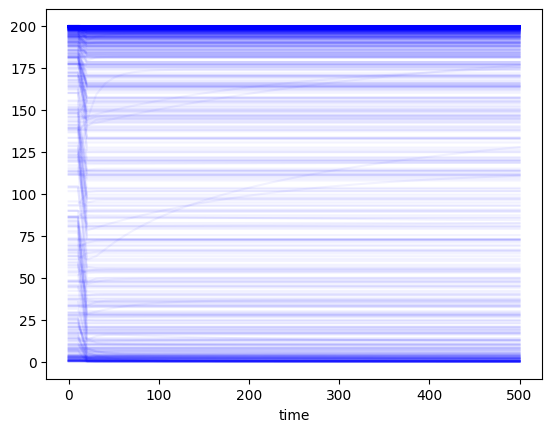

In [8]:
idx_species = -1
plt.plot(np.repeat(ts[None, :], repeats=1000, axis=0).T, ys[:1000, :, idx_species].T, alpha=0.05, color='b')
plt.xlabel('time')

In [9]:
# print(data_writer.top_write_dir)
# data_writer.output(data=analytics, out_type='json', out_name='analytics')
# data_writer.output(data=ys, out_type='npy', out_name='ys')
# data_writer.output(data=ts, out_type='npy', out_name='ts')
# data_writer.output(data=y0m, out_type='npy', out_name='y0m')
# data_writer.output(data=fake_circuits, out_type='npy', out_name='fake_circuits')

In [10]:
analytics['sensitivity_wrt_species-6'] = np.array(analytics['sensitivity_wrt_species-6'])
analytics['precision_wrt_species-6'] = np.array(analytics['precision_wrt_species-6'])
analytics['overshoot'] = np.array(analytics['overshoot'])

In [11]:
idx_species = -1
idx_max = np.argmax(analytics['overshoot'][:, idx_species])

Array([-23.348106 ,   0.       , -12.75588  ,   0.       ,   0.       ,
        -3.2216125], dtype=float32)

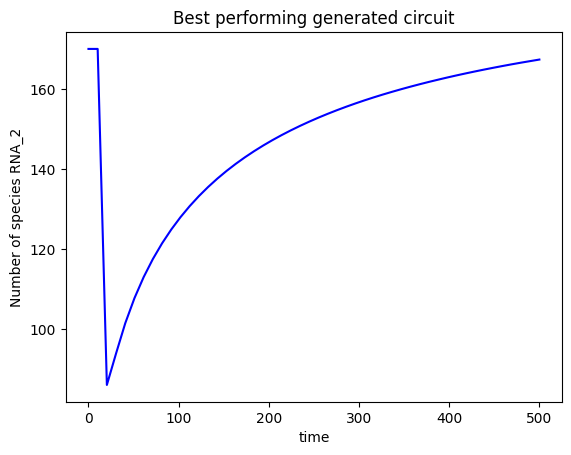

In [12]:
plt.plot(ts, ys[idx_max, :, idx_species].T, color='b')
plt.xlabel('time')
plt.ylabel(f'Number of species {input_species[idx_species]}')
plt.title('Best performing generated circuit')
fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)[idx_max]

# Visualise

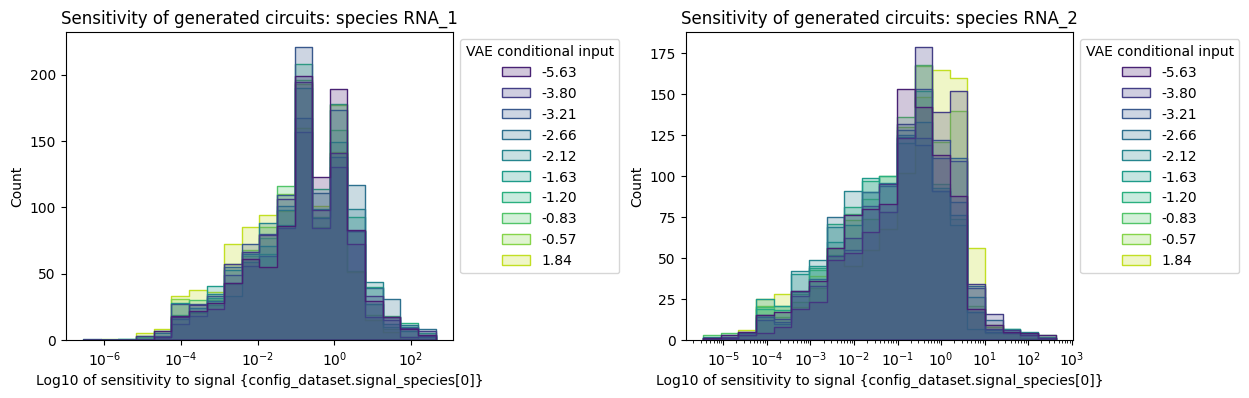

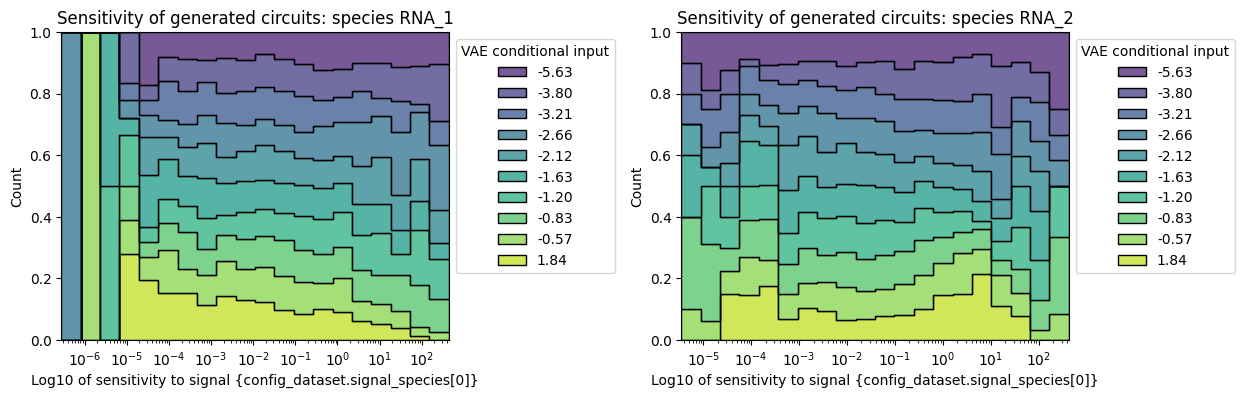

In [13]:
output_species = ['RNA_1', 'RNA_2']

if 'Log sensitivity' not in analytics:
    analytics['Log sensitivity'] = np.log10(analytics['sensitivity_wrt_species-6'])
    analytics['Log precision'] = np.log10(analytics['precision_wrt_species-6'])

vis_sampled_histplot(analytics['sensitivity_wrt_species-6'], y_datanormaliser, model_brn, output_species, # config_dataset.output_species,
                     title=f'Sensitivity of generated circuits', x_label='Log10 of sensitivity to signal {config_dataset.signal_species[0]}', multiple='layer', show=True)

vis_sampled_histplot(analytics['sensitivity_wrt_species-6'], y_datanormaliser, model_brn, output_species, # config_dataset.output_species,
                     title=f'Sensitivity of generated circuits', x_label='Log10 of sensitivity to signal {config_dataset.signal_species[0]}', multiple='fill', show=True)


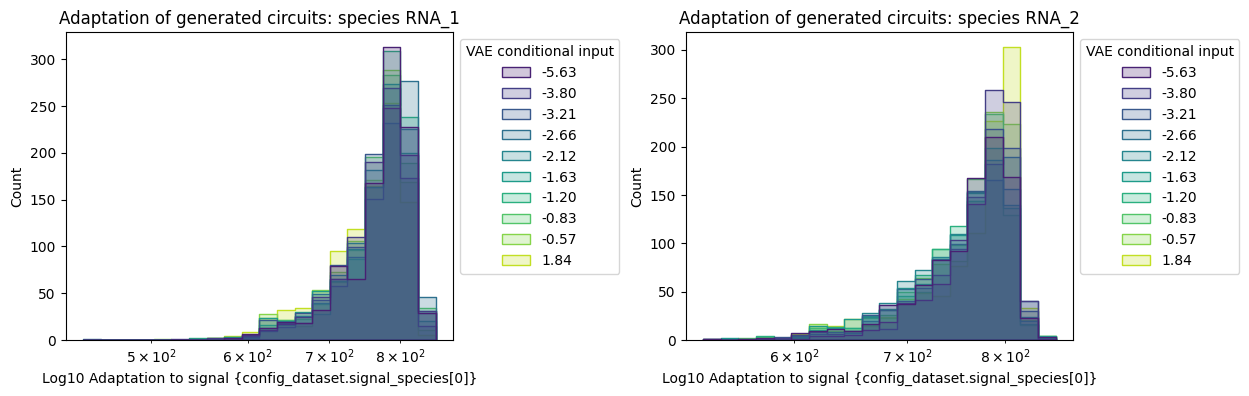

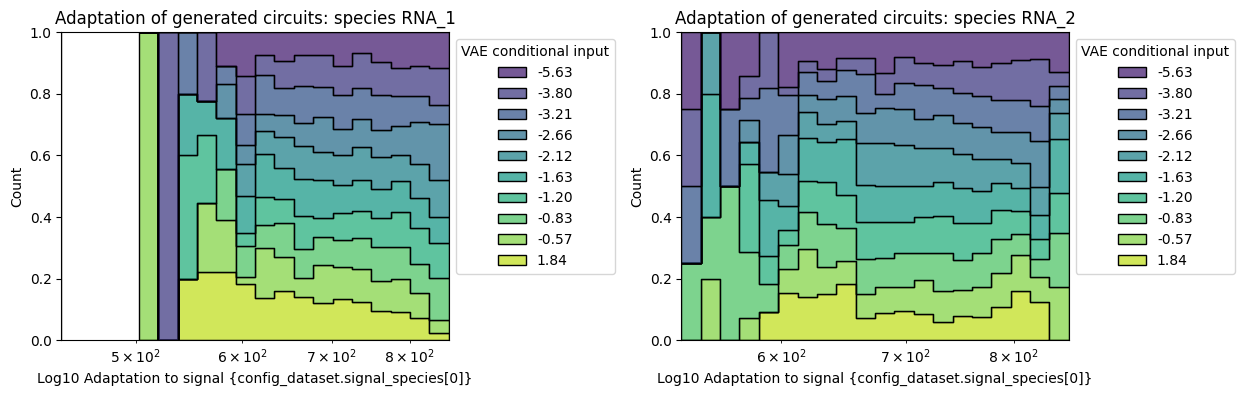

In [14]:
analytics['adaptation'] = calculate_adaptation(
    analytics['sensitivity_wrt_species-6'], analytics['precision_wrt_species-6'])

vis_sampled_histplot(analytics['adaptation'], y_datanormaliser, model_brn, output_species, # config_dataset.output_species,
                     title=f'Adaptation of generated circuits', x_label='Log10 Adaptation to signal {config_dataset.signal_species[0]}', multiple='layer', show=True)

vis_sampled_histplot(analytics['adaptation'], y_datanormaliser, model_brn, output_species, # config_dataset.output_species,
                     title=f'Adaptation of generated circuits', x_label='Log10 Adaptation to signal {config_dataset.signal_species[0]}', multiple='fill', show=True)


/tmp/ipykernel_2643034/2541304395.py:11: RuntimeWarning: divide by zero encountered in log10
  analytics[f'Log {k.split("_")[0]}'] = np.log10(analytics[k])
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appr

Diffs: [ 5.014002   2.9869738  2.3134232  2.0607824  1.3211884  0.8411133
  0.5960165  0.0833981 -0.3485278 -2.968922 ] 18.534348
Diffs: [ 4.750416    3.199992    2.4186385   1.7654178   0.94919395  0.45086908
  0.02101207 -0.16641152 -0.15602225 -2.413011  ] 16.290983


category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


Diffs: [ 2.4519057   0.21348321 -0.04356903 -0.7495183  -1.138096   -1.6717228
 -2.4289145  -2.7604156  -3.1919293  -4.7154894 ] 19.365044
Diffs: [ 2.6727970e+00 -4.2450428e-04 -1.7402369e-01 -5.4119694e-01
 -8.4102023e-01 -1.4131738e+00 -1.9723175e+00 -2.5675273e+00
 -3.3684673e+00 -5.2189360e+00] 18.769884


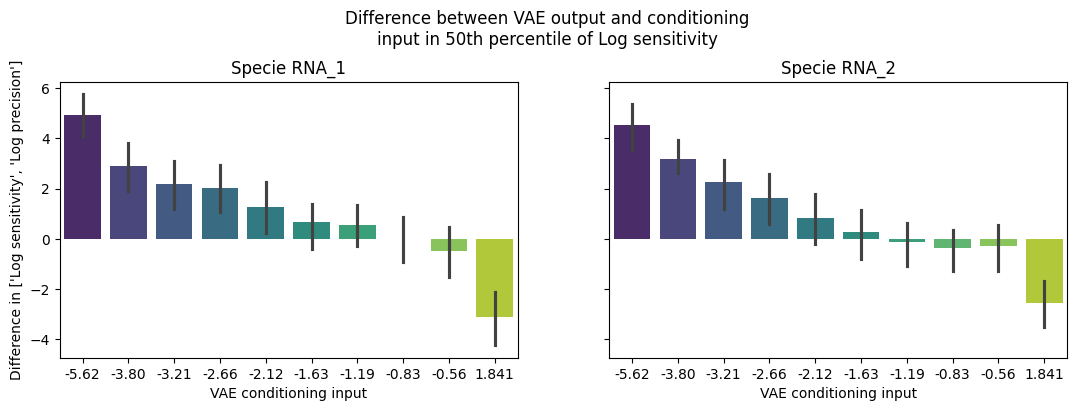

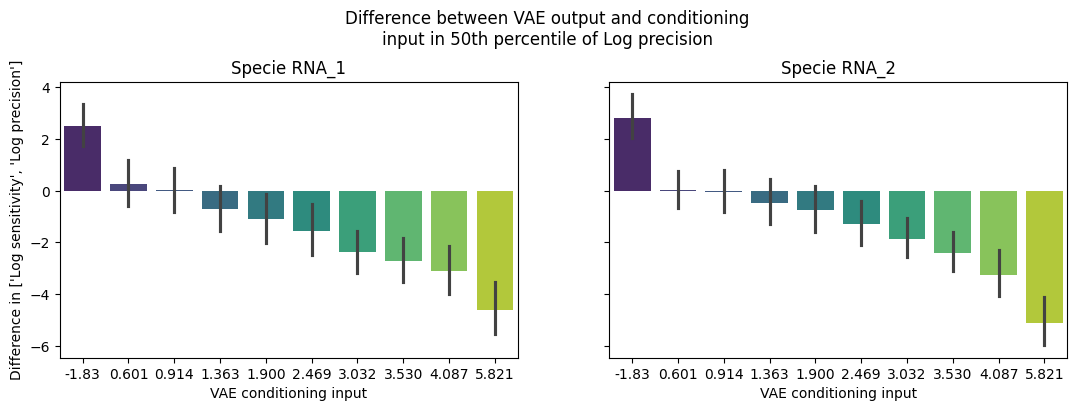

In [19]:
def plot_bar(diffs_conditional_real_sens, sampled_conds, ax, palette='viridis'):
    sns.barplot(pd.DataFrame(diffs_conditional_real_sens.T, columns=[
                str(ii)[:5] for ii in sampled_conds.flatten()]), palette=palette, ax=ax)
    plt.xlabel('VAE conditioning input')
    plt.ylabel(f'Difference in {config_dataset.objective_col}')


for k in ['sensitivity_wrt_species-6', 'precision_wrt_species-6', 'adaptation']:
    analytics[k] = np.where(np.isnan(
        analytics[k]), 0, analytics[k])
    analytics[f'Log {k.split("_")[0]}'] = np.log10(analytics[k])
n_categories = fake_circuits.shape[0]

for k in config_dataset.objective_col:
    sampled_conds = np.array(
        sorted(y_datanormaliser.metadata[k]['category_map'].values()))

    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13, 4))
    fig.subplots_adjust(hspace=0.3, top=0.8)
    for i, output_specie in enumerate(output_species):
        output_idx = [s.name for s in model_brn.species].index(output_specie)
        diffs_conditional_real_sens = jax.vmap(lambda xxx: jnp.percentile(xxx, q=np.array([25, 50, 75])))(
            analytics[k][:, output_idx].reshape(fake_circuits.shape[0], n_to_sample)) - sampled_conds[:, None]

        plt.axes(axs[i])
        plot_bar(diffs_conditional_real_sens, sampled_conds, axs[i])
        plt.title(f'Specie {output_specie}')
        print('Diffs:', diffs_conditional_real_sens[:, 1], np.sum(
            np.abs(diffs_conditional_real_sens[:, 1])))

    plt.suptitle(
        f'Difference between VAE output and conditioning\ninput in 50th percentile of {k}')

category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


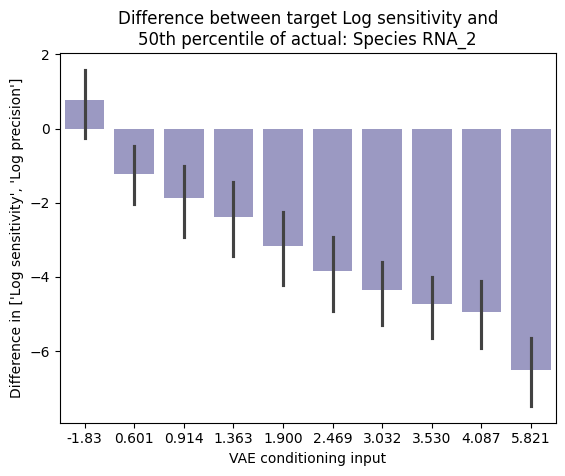

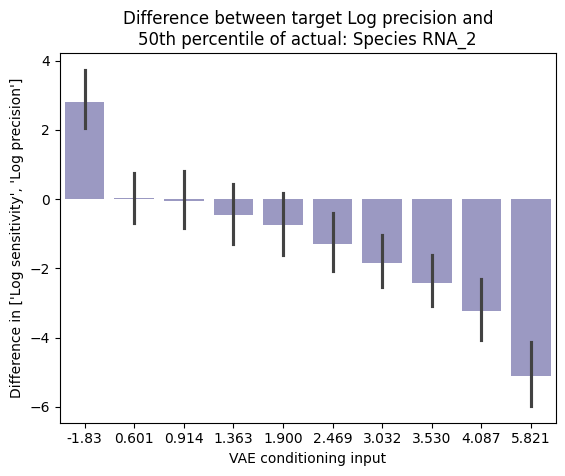

In [23]:
for k in config_dataset.objective_col:
    plt.figure()
    output_idx = [i.name for i in model_brn.species].index(
        config_dataset.output_species[0])
    diffs_conditional_real_sens = jax.vmap(lambda xxx: jnp.percentile(xxx, q=np.array([25, 50, 75])))(
        analytics[k][:, output_idx].reshape(fake_circuits.shape[0], n_to_sample)) - sampled_conds[:, None]
    plot_bar(diffs_conditional_real_sens, sampled_conds, plt.subplot(1, 1, 1),
            palette=sns.cubehelix_palette(start=3, rot=0, dark=0.6, light=.6, reverse=False, as_cmap=False, n_colors=n_categories))
    #  palette=sns.cubehelix_palette(start=1, rot=1.5, dark=0.3, light=.7, reverse=False, as_cmap=False, n_colors=10))
    plt.title(
        f'Difference between target {k} and\n50th percentile of actual: Species {config_dataset.output_species[0]}')

category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


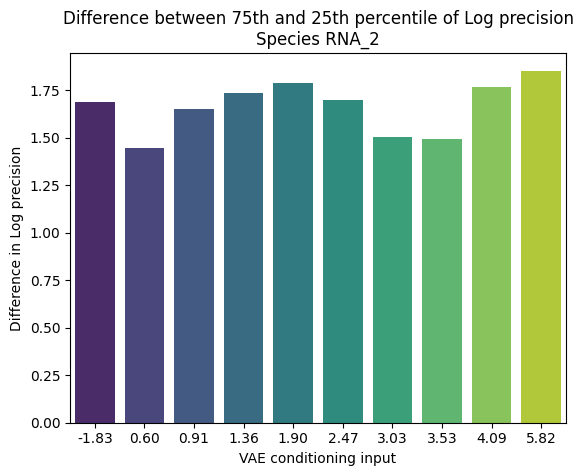

In [24]:
for k in config_dataset.objective_col:
    sns.barplot(pd.DataFrame((diffs_conditional_real_sens[..., -1] - diffs_conditional_real_sens[..., 0])[None, :], columns=[
                f'{ii:.2f}' for ii in sampled_conds.flatten()]), palette='viridis')
    txt = 'sensitivity' if 'sensitivity' in k else ('adaptation' if 'adaptation' in k else k)
    plt.title(f'Difference between 75th and 25th percentile of {txt}\nSpecies {config_dataset.output_species[0]}')
    plt.xlabel('VAE conditioning input')
    plt.ylabel(f'Difference in {k}')

Text(0.5, 0.98, 'Generated circuits: sensitivity vs. precision')

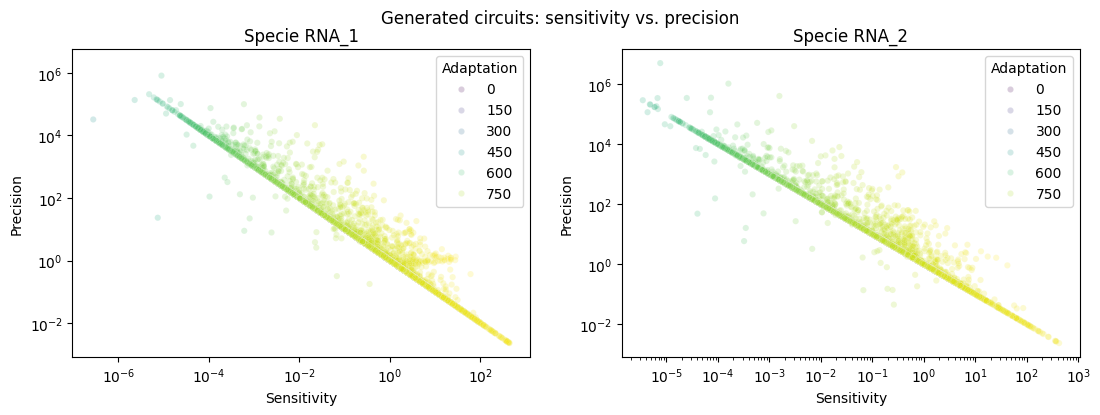

In [25]:
fig = plt.figure(figsize=(13, 4))

category_array = np.array(sorted(y_datanormaliser.metadata[config_dataset.objective_col[0]]["category_map"].values())).repeat(
    len(analytics['sensitivity_wrt_species-6'])//len(y_datanormaliser.metadata[config_dataset.objective_col[0]]["category_map"]))
for i, output_specie in enumerate(output_species):
    output_idx = [s.name for s in model_brn.species].index(output_specie)
    d = pd.DataFrame()
    d['Sensitivity'] = analytics['sensitivity_wrt_species-6'][:, output_idx]
    d['Precision'] = analytics['precision_wrt_species-6'][:, output_idx]
    d['Adaptation'] = analytics['adaptation'][:, output_idx]
    d['VAE conditioning input'] = category_array
    ax = plt.subplot(1,2,i+1)
    sns.scatterplot(d, x='Sensitivity', y='Precision', alpha=0.2, hue='Adaptation', palette='viridis', s=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Specie {output_specie}')
plt.suptitle('Generated circuits: sensitivity vs. precision')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

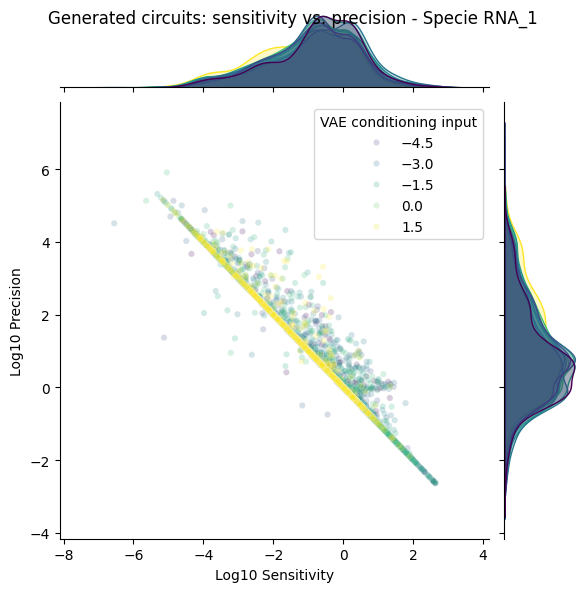

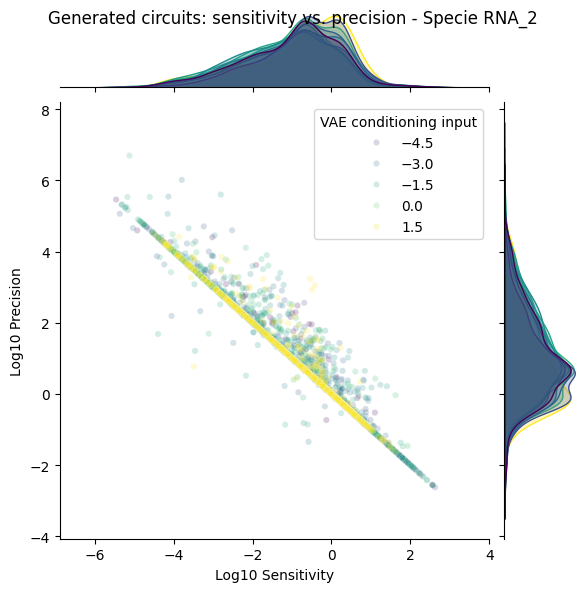

In [26]:
# fig = plt.figure(figsize=(13, 4))
plt.subplots_adjust(top=0.8)

category_array = np.array(sorted(y_datanormaliser.metadata[config_dataset.objective_col[0]]["category_map"].values())).repeat(
    len(analytics['sensitivity_wrt_species-6'])//len(y_datanormaliser.metadata[config_dataset.objective_col[0]]["category_map"]))
for i, output_specie in enumerate(output_species):
    output_idx = [s.name for s in model_brn.species].index(output_specie)
    d = pd.DataFrame()
    d['Sensitivity'] = analytics['sensitivity_wrt_species-6'][:, output_idx]
    d['Precision'] = analytics['precision_wrt_species-6'][:, output_idx]
    d['Adaptation'] = analytics['adaptation'][:, output_idx]
    d['Log10 Sensitivity'] = np.log10(d['Sensitivity'])
    d['Log10 Precision'] = np.log10(d['Precision'])
    d['VAE conditioning input'] = category_array
    # ax = plt.subplot(1,2,i+1)
    # sns.jointplot(d, x='Log10 Sensitivity', y='Log10 Precision', alpha=0.2, hue='Adaptation', palette='viridis', s=20)
    sns.jointplot(d, x='Log10 Sensitivity', y='Log10 Precision', alpha=0.2, hue='VAE conditioning input', palette='viridis', s=20)
    # plt.title(f'Specie {output_specie}')
    plt.suptitle(f'Generated circuits: sensitivity vs. precision - Specie {output_specie}')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))